In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import time
import ignite
import numpy as np
import sklearn.metrics
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms
from typing import List, Callable
import pickle
import tqdm
import pytorch_lightning as pl
import torchmetrics
import os.path
import cv2
import csv
import pandas as pd
#from google.colab import drive
from google.colab.patches import cv2_imshow
import fnmatch
from math import sqrt
from PIL import Image
import joblib
from torch_lr_finder import LRFinder
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.loggers import TensorBoardLogger
import tensorflow as tf
from matplotlib import pyplot as plt

/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


In [3]:
print(torch.cuda.is_available())
print(torch.__version__)

True
1.8.1+cu101


## Parameters

In [4]:
BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-4
WD = 1e-4

## Data Classes

In [5]:
# Modificamos la carpeta 
print(os.getcwd())
try:
    print(os.listdir("Pruebas ImitAI"))
    os.chdir("Pruebas ImitAI/Dataset_100_1")
except:
    print(os.listdir("../../Pruebas ImitAI"))
    os.chdir("../../Pruebas ImitAI/Dataset_100_1")
#os.chdir("../Prueba")
os.listdir()

/home/hodei.zia/ImitAI Project
['2000 pruebas', '2000_Pruebas', 'MuJoCo_Dataset', 'Dataset_Mujoco']


['Train_dataset', 'Test_dataset', 'MinMax_scaler.save', 'CP', 'CP2']

In [6]:
os.getcwd()

'/home/hodei.zia/ImitAI Project/Pruebas ImitAI/Dataset_Mujoco/Dataset_Mujoco'

### Normalizamos las acciones y obtenemos el array de tamaños

In [7]:
print(os.getcwd())
print(os.listdir())

# Velocities
with open('Train_dataset/Train_Actions.csv') as f:
    lines = (line for line in f if not line.startswith('#'))
    x = np.loadtxt(lines, delimiter=',', skiprows=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
x_transformed = scaler.fit_transform(x)
np.savetxt('Train_dataset/Train_Actions_Normalized.csv',x_transformed , delimiter=',', header="X1,X2,X3")

with open('Test_dataset/Test_Actions.csv') as f:
    lines = (line for line in f if not line.startswith('#'))
    x = np.loadtxt(lines, delimiter=',', skiprows=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
x_transformed = scaler.fit_transform(x)
np.savetxt('Test_dataset/Test_Actions_Normalized.csv',x_transformed , delimiter=',', header="X1,X2,X3")

/home/hodei.zia/ImitAI Project/Pruebas ImitAI/Dataset_Mujoco/Dataset_Mujoco
['Train_dataset', 'Test_dataset', 'MinMax_scaler.save', 'CP', 'CP2']


In [8]:
scaler_filename = "MinMax_scaler.save"
scaler_to_save = MinMaxScaler(feature_range=(-1, 1))
joblib.dump(scaler_to_save, scaler_filename) 
scaler_loaded = joblib.load(scaler_filename)

In [9]:
'''
t_list = ["Train_dataset", "Test_dataset"]
ty_list = ["Top", "Corner", "Corner2", "Corner3", "Gripper", "BehindGripper"]
count = 0
for t in t_list:
    for ty in ty_list:
        f = str(t + "/" + ty)
        print(f)
        for file in os.listdir(f):
            f_img = f+"/"+file
            img = Image.open(f_img)
            img = img.resize((128,128))
            img.save(f_img)
            count += 1
            if count % 500 == 0:
                print(count)
'''

'\nt_list = ["Train_dataset", "Test_dataset"]\nty_list = ["Top", "Corner", "Corner2", "Corner3", "Gripper", "BehindGripper"]\ncount = 0\nfor t in t_list:\n    for ty in ty_list:\n        f = str(t + "/" + ty)\n        print(f)\n        for file in os.listdir(f):\n            f_img = f+"/"+file\n            img = Image.open(f_img)\n            img = img.resize((128,128))\n            img.save(f_img)\n            count += 1\n            if count % 500 == 0:\n                print(count)\n'

In [22]:
# Clases para mas de una imagen

class ObsActionGetter(object):
    """
    Generic class that return the image and the action given an index
    """
    def __init__(self, carpeta_imagenes, archivo_acciones):
        # TODO: get a list of all image files
        self.archivo_acciones = archivo_acciones
        self.carpeta_imagenes = carpeta_imagenes
        path, dirs, files = next(os.walk(self.carpeta_imagenes))
        self.image_files = list(range(len(files)))
        # TODO: get all made actions
        self.actions = []
        
    def __len__(self):
        return len(fnmatch.filter(os.listdir(self.carpeta_imagenes + "Top/"), '*.png'))
        
    def __getitem__(self, idx):
        path_1 = self.carpeta_imagenes + "Top/" + str(idx) + ".png"
        path_2 = self.carpeta_imagenes + "Corner/" + str(idx) + ".png"
        path_3 = self.carpeta_imagenes + "Corner2/" + str(idx) + ".png"
        path_4 = self.carpeta_imagenes + "Corner3/" + str(idx) + ".png"
        path_5 = self.carpeta_imagenes + "Gripper/" + str(idx) + ".png"
        path_6 = self.carpeta_imagenes + "BehindGripper/" + str(idx) + ".png"
        
        im1 = np.array(Image.open(path_1))
        im2 = np.array(Image.open(path_2))
        im3 = np.array(Image.open(path_3))
        im4 = np.array(Image.open(path_4))
        im5 = np.array(Image.open(path_5))
        im6 = np.array(Image.open(path_6))
        
        if (idx % 25 == 0):
            im7 = np.array(Image.open(path_1))
            im8 = np.array(Image.open(path_2))
            im9 = np.array(Image.open(path_3))
            im10 = np.array(Image.open(path_4))
            im11 = np.array(Image.open(path_5))
            im12 = np.array(Image.open(path_6))
            
        else :
            path_7 = self.carpeta_imagenes + "Top/" + str(idx-1) + ".png"
            path_8 = self.carpeta_imagenes + "Corner/" + str(idx-1) + ".png"
            path_9 = self.carpeta_imagenes + "Corner2/" + str(idx-1) + ".png"
            path_10 = self.carpeta_imagenes + "Corner3/" + str(idx-1) + ".png"
            path_11 = self.carpeta_imagenes + "Gripper/" + str(idx-1) + ".png"
            path_12 = self.carpeta_imagenes + "BehindGripper/" + str(idx-1) + ".png"
            
            im7 = np.array(Image.open(path_7))
            im8 = np.array(Image.open(path_8))
            im9 = np.array(Image.open(path_9))
            im10 = np.array(Image.open(path_10))
            im11 = np.array(Image.open(path_11))
            im12 = np.array(Image.open(path_12))
            
        
        # TODO: get the action
        data = pd.read_csv(self.archivo_acciones, header = None)
        action = np.float32(np.array(data.iloc[idx]))
        
        if (idx % 25 == 0):
            action_prev_1 = np.array([0,0,0,0], dtype="float32")
            action_prev_2 = np.array([0,0,0,0], dtype="float32")
            action_prev_3 = np.array([0,0,0,0], dtype="float32")
            action_prev_4 = np.array([0,0,0,0], dtype="float32")
            action_prev_5 = np.array([0,0,0,0], dtype="float32")
            
        elif ((idx-1) % 25 == 0):
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.array([0,0,0,0], dtype="float32")
            action_prev_3 = np.array([0,0,0,0], dtype="float32")
            action_prev_4 = np.array([0,0,0,0], dtype="float32")
            action_prev_5 = np.array([0,0,0,0], dtype="float32")
            
        elif ((idx-2) % 25 == 0):
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.float32(np.array(data.iloc[idx-2]))
            action_prev_3 = np.array([0,0,0,0], dtype="float32")
            action_prev_4 = np.array([0,0,0,0], dtype="float32")
            action_prev_5 = np.array([0,0,0,0], dtype="float32")
            
        elif ((idx-3) % 25 == 0):
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.float32(np.array(data.iloc[idx-2]))
            action_prev_3 = np.float32(np.array(data.iloc[idx-3]))
            action_prev_4 = np.array([0,0,0,0], dtype="float32")
            action_prev_5 = np.array([0,0,0,0], dtype="float32")
            
        elif ((idx-4) % 25 == 0):
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.float32(np.array(data.iloc[idx-2]))
            action_prev_3 = np.float32(np.array(data.iloc[idx-3]))
            action_prev_4 = np.float32(np.array(data.iloc[idx-4]))
            action_prev_5 = np.array([0,0,0,0], dtype="float32")
            
        else:
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.float32(np.array(data.iloc[idx-2]))
            action_prev_3 = np.float32(np.array(data.iloc[idx-3]))
            action_prev_4 = np.float32(np.array(data.iloc[idx-4]))
            action_prev_5 = np.float32(np.array(data.iloc[idx-5]))
            
        im_actual = np.concatenate((im1, im2, im3, im4, im5, im6), axis=2)
        im_previa = np.concatenate((im7, im8, im9, im10, im11, im12), axis=2)
        imagen = np.concatenate((im_actual, im_previa), axis=2) # Canales = 2, Anchura = 1 -> 1,1,1...1,2
        
        # Return both image and action
        return imagen, action, action_prev_1, action_prev_2, action_prev_3, action_prev_4, action_prev_5

class ObsActionDataset(Dataset):
    """
    PyTorch Dataset for getting the data. In this case, from ObsActionGetter object
    """
    def __init__(self, obs_action_getter: ObsActionGetter, transformations: List[Callable]):
        print('OBSACTIONDATASET_INIT')
        super(ObsActionDataset, self).__init__()
        self.obs_action_getter = obs_action_getter
        self.transformations = transformations
        
    def __len__(self):
        return len(self.obs_action_getter)
    
    def __getitem__(self, idx):
        imagen, action, action_prev_1, action_prev_2, action_prev_3, action_prev_4, action_prev_5 = self.obs_action_getter[idx]
        for t in self.transformations:
            imagen = t(imagen)
        # Return both image and action
        return (imagen, action_prev_1, action_prev_2, action_prev_3, action_prev_4, action_prev_5), action
    
class MultiImage(nn.Module):
    def __init__(self, fe, clf):
        super(MultiImage, self).__init__()
        self.fe = fe
        self.clf = clf
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x1, x2, x3, x4, x5, x6 = x
        f1 = self.fe(x1)
        f = self.flatten(self.avg_pool(f1))
        f = torch.cat((f, x2, x3, x4, x5, x6), dim=1)
        return self.clf(f)

ERROR! Session/line number was not unique in database. History logging moved to new session 849


In [23]:
print(len(fnmatch.filter(os.listdir('Test_dataset/Top'), '*.png')))
print(len(fnmatch.filter(os.listdir('Test_dataset/Corner'), '*')))
print(len(fnmatch.filter(os.listdir('Test_dataset/Corner2'), '*')))
print(len(fnmatch.filter(os.listdir('Test_dataset/Corner3'), '*')))
print(len(fnmatch.filter(os.listdir('Test_dataset/Gripper'), '*')))
print(len(fnmatch.filter(os.listdir('Test_dataset/BehindGripper'), '*')))
print(len(fnmatch.filter(os.listdir('Train_dataset/Top'), '*.png')))
print(len(fnmatch.filter(os.listdir('Train_dataset/Corner'), '*')))
print(len(fnmatch.filter(os.listdir('Train_dataset/Corner2'), '*')))
print(len(fnmatch.filter(os.listdir('Train_dataset/Corner3'), '*')))
print(len(fnmatch.filter(os.listdir('Train_dataset/Gripper'), '*')))
print(len(fnmatch.filter(os.listdir('Train_dataset/BehindGripper'), '*')))

10500
10500
10500
10500
10500
10500
42000
42000
42000
42000
42000
42000


In [24]:
# Para mas de una imagen

# Create train Dataset.
# The ToTensor transform converts the image to Tensor in [0, 1] range and makes it channel first
# The Normalize transform normalizes the tensor using Imagenet stats

train_obs_action_getter = ObsActionGetter('Train_dataset/', 'Train_dataset/Train_Actions.csv')
train_dataset = ObsActionDataset(train_obs_action_getter, 
                                [
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406, 0.485, 0.456, 0.406, 0.485, 0.456, 0.406, 
                                                          0.485, 0.456, 0.406, 0.485, 0.456, 0.406, 0.485, 0.456, 0.406, 
                                                          0.485, 0.456, 0.406, 0.485, 0.456, 0.406, 0.485, 0.456, 0.406, 
                                                          0.485, 0.456, 0.406,0.485, 0.456, 0.406, 0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225, 0.229, 0.224, 0.225, 0.229, 0.224, 0.225,
                                                          0.229, 0.224, 0.225, 0.229, 0.224, 0.225, 0.229, 0.224, 0.225, 
                                                          0.229, 0.224, 0.225, 0.229, 0.224, 0.225, 0.229, 0.224, 0.225, 
                                                          0.229, 0.224, 0.225, 0.229, 0.224, 0.225, 0.229, 0.224, 0.225))
                                ])

# Create test Dataset.
# The ToTensor transform converts the image to Tensor in [0, 1] range and makes it channel first
# The Normalize transform normalizes the tensor using Imagenet stats

test_obs_action_getter = ObsActionGetter('Test_dataset/', 'Test_dataset/Test_Actions.csv')
test_dataset = ObsActionDataset(test_obs_action_getter, 
                                [
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406, 0.485, 0.456, 0.406, 0.485, 0.456, 0.406, 
                                                          0.485, 0.456, 0.406, 0.485, 0.456, 0.406, 0.485, 0.456, 0.406, 
                                                          0.485, 0.456, 0.406, 0.485, 0.456, 0.406, 0.485, 0.456, 0.406, 
                                                          0.485, 0.456, 0.406,0.485, 0.456, 0.406, 0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225, 0.229, 0.224, 0.225, 0.229, 0.224, 0.225,
                                                          0.229, 0.224, 0.225, 0.229, 0.224, 0.225, 0.229, 0.224, 0.225, 
                                                          0.229, 0.224, 0.225, 0.229, 0.224, 0.225, 0.229, 0.224, 0.225, 
                                                          0.229, 0.224, 0.225, 0.229, 0.224, 0.225, 0.229, 0.224, 0.225))
                                ])

OBSACTIONDATASET_INIT
OBSACTIONDATASET_INIT


In [25]:
%%time
# Create loaders (class that groups examples in batches)
# Uriz: train DataLoader should have shuffle to True
# Uriz: test DataLoader should have drop_last to False
# Uriz: use more workers to improve the training speed (load data in sever CPU threads). Otherwise we have a CPU -> GPU bottleneck
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=16)

print(len(train_dataset))
print(len(train_loader))
print(len(test_dataset))
print(len(test_loader))

42000
1312
10500
329
CPU times: user 148 ms, sys: 51.5 ms, total: 199 ms
Wall time: 197 ms


In [26]:
print(train_obs_action_getter[1][0].shape)
for i in range(29,34):
    print("\nAccion Actual:", train_obs_action_getter[i][1])
    print("Accion Previa - 1:", train_obs_action_getter[i][2])
    print("Accion Previa - 2:", train_obs_action_getter[i][3])
    print("Accion Previa - 3:", train_obs_action_getter[i][4])
    print("Accion Previa - 4:", train_obs_action_getter[i][5])
    print("Accion Previa - 5:", train_obs_action_getter[i][6])

(128, 128, 36)

Accion Actual: [-0.4505956   1.3354287  -0.07553109  0.        ]
Accion Previa - 1: [-0.58043075  1.4727268  -0.09094159  0.        ]
Accion Previa - 2: [-0.6817964  1.5709357 -0.1002648  0.       ]
Accion Previa - 3: [-0.74374986  1.623395   -0.10444193  0.        ]
Accion Previa - 4: [-0.7633638   1.6345876  -0.10752937  0.        ]
Accion Previa - 5: [0. 0. 0. 0.]

Accion Actual: [-0.30707434  1.1680573  -0.05464435  0.        ]
Accion Previa - 1: [-0.4505956   1.3354287  -0.07553109  0.        ]
Accion Previa - 2: [-0.58043075  1.4727268  -0.09094159  0.        ]
Accion Previa - 3: [-0.6817964  1.5709357 -0.1002648  0.       ]
Accion Previa - 4: [-0.74374986  1.623395   -0.10444193  0.        ]
Accion Previa - 5: [-0.7633638   1.6345876  -0.10752937  0.        ]

Accion Actual: [-0.16378444  0.9799393  -0.03032465  0.        ]
Accion Previa - 1: [-0.30707434  1.1680573  -0.05464435  0.        ]
Accion Previa - 2: [-0.4505956   1.3354287  -0.07553109  0.        ]
Acc

In [27]:
it = iter(test_loader)
first = next(it)
second = next(it)
print(it)


## Model

We use a pretrained ResNet18 for now. We have to remove the classifier head because it is traiend for classification with 1000 classes. We add a custom head to make regression of 7 values

In [28]:
# To pretrain
model = models.resnet18(pretrained=False)

# Change the first convolution
new_conv = torch.nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model = list(model.children())[1:]
model = [new_conv] + model
model = torch.nn.Sequential(*model)

# Get only the feature extractor (remove avgpool and fc layers)
fe = nn.Sequential(*list(model.children())[:-2])

def freeze_all_but_bn(m):
    """
    Function that set a module as no trainable (not required grad) only if it is not a BatchNorm module
    Args:
        m: PyTorch Module
    """
    if not isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
        if hasattr(m, 'weight') and m.weight is not None:
            m.weight.requires_grad_(False)
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.requires_grad_(False)
            
def unfreeze_all_but_bn(m):
    """
    Function that set a module as no trainable (not required grad) only if it is not a BatchNorm module
    Args:
        m: PyTorch Module
    """
    if not isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
        if hasattr(m, 'weight') and m.weight is not None:
            m.weight.requires_grad_(True)
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.requires_grad_(True)
            
# Freeze all but BatchNorm layers of feature extractor
# Uriz: if we use the "normal" ResNet use the pretained version and freeze all but BN
#       only set all trainiable when we change the fitst convolution layer to accept images of 6 dimensions
#       if the ResNet is pretrained and freezed the training accuracy is maintained (or increased) and the train time is dreceased
fe.apply(freeze_all_but_bn) # Solo usar si no se preentrena la red

# Create custom head
head_clf = nn.Sequential(
    nn.BatchNorm1d(512*5+7),
    nn.Dropout(0.25),
    nn.Linear(512*5+7, 512), 
    nn.ReLU(),
    nn.BatchNorm1d(512),   
    nn.Dropout(0.25),
    nn.Linear(512, 7)
)

# Rebuild the model
model = MultiImage(fe, head_clf)

## Train Model

In [29]:
# Create trainable class with Pytorch Lightinng
class LitModel(pl.LightningModule):
    def __init__(self, model, loss_function, total_iterations, lr):
        """
        Constructor of the trainable class
        Args:
            model: PyTorch model
            loss_function: The loss function to use
            total_iterations: The total number of iterations for training (num_batches * num_epochs). Used for
                                LR Schedule
            lr: the max_lr to use for the OneCycleLR policy
        """
        super().__init__()
        # Store params
        self.model = model
        self.loss_function = loss_function
        self.total_iterations = total_iterations
        self.lr = lr
        # For measure the MSE
        self.train_mse = torchmetrics.MeanSquaredError()
        self.valid_mse = torchmetrics.MeanSquaredError()

    def forward(self, x):
        # Forward method
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        prediction = self(x)
        loss = self.loss_function(prediction, y)
        # Get MSE
        self.train_mse(prediction, y)
        # Log loss and MSE
        self.log("training_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_mse', self.train_mse, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        # Return Loss for backward
        return loss

    def training_epoch_end(self, outs):
        # log epoch metric
        self.log('train_acc_epoch', self.train_mse.compute(), logger=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        prediction = self(x)
        loss = self.loss_function(prediction, y)
        # Get MSE
        self.valid_mse(prediction, y)
        # Log loss and MSE
        self.log('valid_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_mse', self.valid_mse, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_epoch_end(self, outs):
        # log epoch metric
        self.log('val_acc_epoch', self.valid_mse.compute(), logger=True)

    def configure_optimizers(self):
        # Get Adam optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        # Set OneCycleLR policy
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.lr,
                                                             total_steps=self.total_iterations),
            'interval': 'step', 'frequency': 1, 'name': 'lr_logger'
        }
        return [optimizer], [lr_scheduler]

In [30]:
class CallbackClass(Callback):
    def __init__(self, what="epochs", verbose=True):
        self.what = what
        self.verbose = verbose
        self.state = {"epochs": 0}
        
    @property
    def state_key(self):
        # note: we do not include `verbose` here on purpose
        return self._generate_state_key(what=self.what)

    def on_train_epoch_end(self, *args, **kwargs):
        e = 0
        if self.what == "epochs":
            self.state["epochs"] += 1
            
        if self.state["epochs"] >= 5:
            for param in pl_model.parameters():
                param.requires_grad = True # Unfreeze
        
        for name, param in pl_model.named_parameters():
            if param.requires_grad:
                e = e+1

    def load_state_dict(self, state_dict):
        self.state.update(state_dict)

    def state_dict(self):
        return self.state.copy()

## Bucle to obtain all the info for differents Epochs

In [31]:
RMSE_List = []
Model_List = []
Prediction_List = []
Label_List = []
LR_List = []
Loss_List = []

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.15E-02


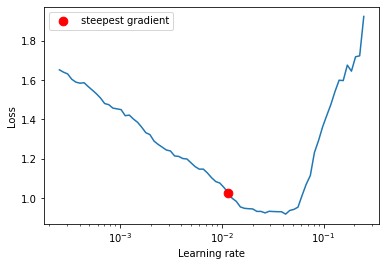

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 11.6 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
286 K     Trainable params
11.3 M    Non-trainable params
11.6 M    Total params
46.228    Total estimated model params size (MB)


0.011497569953977356
EPOCH NUMERO: 1


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

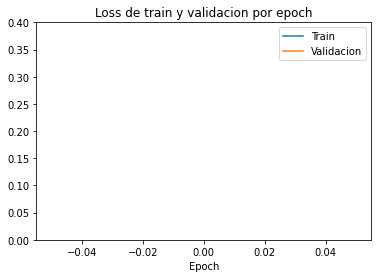

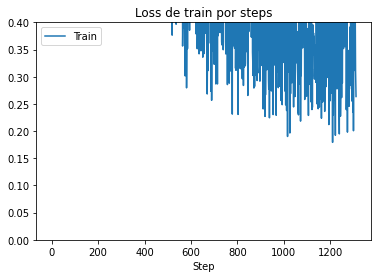

  0%|          | 0/329 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 280.96042
El valor RMSE es igual a 16.76187396149881
[16.76187396149881]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.96E-03


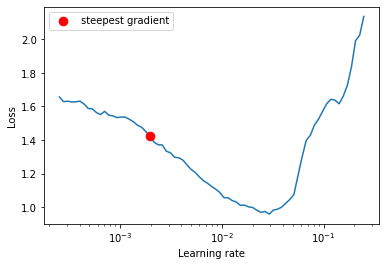

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 11.6 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
286 K     Trainable params
11.3 M    Non-trainable params
11.6 M    Total params
46.228    Total estimated model params size (MB)


0.0019630406500402713
EPOCH NUMERO: 2


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

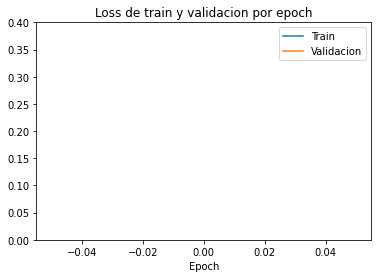

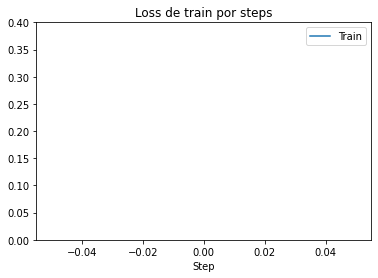

  0%|          | 0/329 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.14113545
El valor RMSE es igual a 0.3756799890569851
[16.76187396149881, 0.3756799890569851]


In [32]:
Epoch_List = [1,2]
num = len(os.listdir("../../../tb_logs/my_model"))
for eps in Epoch_List:
    
    # 1 - Se genera la red
    
    # To pretrain
    model = models.resnet18(pretrained=False)

    # Change the first convolution
    new_conv = torch.nn.Conv2d(36, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model = list(model.children())[1:]
    model = [new_conv] + model
    model = torch.nn.Sequential(*model)

    # Get only the feature extractor (remove avgpool and fc layers)
    fe = nn.Sequential(*list(model.children())[:-2])

    fe.apply(freeze_all_but_bn) # Solo usar si no se preentrena la red

    # Create custom head
    head_clf = nn.Sequential(
    nn.BatchNorm1d(512+4*5),
    nn.Dropout(0.25),
    nn.Linear(512+4*5, 512), 
    nn.ReLU(),
    nn.BatchNorm1d(512),   
    nn.Dropout(0.25),
    nn.Linear(512, 4)
    )

    # Rebuild the model
    model = MultiImage(fe, head_clf)
    
    # 2 - Se busca el mejor Learning Rate a aplicar como maximo posible
    
    # Loss function
    criterion = nn.MSELoss()

    # We catch the optimizer of our lit_model
    # optimizer, lr_scheduler = pl_model.configure_optimizers()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Learning State Finder
    lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
    lr_finder.range_test(train_loader, end_lr=1, num_iter=100, step_mode="exp")

    # Create trainer class
    try:
        BEST_LR = lr_finder.plot()[1]
    except:
        BEST_LR = 5.0E-03
    print(BEST_LR)
    
    if BEST_LR > 0.09:
        BEST_LR = 5.0E-03

    # 3 - Se prepara el Trainer y se entrena con el modelo LitModel
    
    # Number of iterations for LR Schedule
    ITERATIONS_PER_EPOCH = len(train_loader)
    
    logger = TensorBoardLogger("/home/hodei.zia/ImitAI Project/tb_logs", name="my_model")

    # Create PytorchLighting model for training
    pl_model = LitModel(model, criterion, total_iterations=ITERATIONS_PER_EPOCH * eps, lr=BEST_LR)

    NUM_GPUS = 1 if torch.cuda.is_available() else 0
    
    # Create trainer class
    trainer = pl.Trainer(auto_lr_find=True, min_epochs=eps, max_epochs=eps,
                         log_every_n_steps=1, gpus=NUM_GPUS, callbacks=[CallbackClass(what="epochs")], logger=logger)

    print("EPOCH NUMERO: " + str(eps))
    
    # Train the model
    trainer.fit(pl_model, train_loader, val_dataloaders=test_loader)
    
    erroresTrainEpoch=[]
    erroresValEpoch=[]
    erroresTrainStep=[]
    erroresValStep=[]
    
    PATH_TB = os.listdir("../../../tb_logs/my_model/version_" + str(num))[1]
    PATH = "/home/hodei.zia/ImitAI Project/tb_logs/my_model/version_" + str(num) + "/"
    path_to_events_file = PATH + PATH_TB
    num = num + 1
    
    # Plot de LOSS 
    for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
        for v in e.summary.value:
            if v.tag == 'training_loss_epoch':
                erroresTrainEpoch.append(v.simple_value)
            if v.tag == 'valid_loss_epoch':
                erroresValEpoch.append(v.simple_value)

            if v.tag == 'training_loss_step':
                erroresTrainStep.append(v.simple_value)
            #if v.tag == 'valid_loss_step':
            #    erroresValStep.append(v.simple_value)

    plt.plot(erroresTrainEpoch, label='Train')
    plt.plot(erroresValEpoch, label='Validacion')
    plt.title("Loss de train y validacion por epoch")
    plt.xlabel("Epoch")
    plt.ylim(0,0.4)
    plt.legend()
    plt.show()

    plt.plot(erroresTrainStep, label='Train')
    #plt.plot(erroresValStep, label='Validacion')
    plt.title("Loss de train por steps")
    plt.xlabel("Step")
    plt.ylim(0,0.4)
    plt.legend()
    plt.show()
    
    # 4 - Se predice el resultado
    
    # Put model on eval mode so we change the BatchNorm and Dropout layers behaviour
    model = model.eval()
    # Set device ("cuda" or GPU if cuda is installed, otherwise in "cpu")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    # To concatenate predictions and labels
    predictions = None
    labels = None
    # Surround all for not computing gradients
    with torch.no_grad():
        # Iterate over test dataset
        for x, y in tqdm.notebook.tqdm(test_loader):
            # Move to device
            x1, x2, x3, x4, x5, x6 = x
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            x6 = x6.to(device)
            
            # Predict
            o = model((x1, x2, x3, x4, x5, x6))
            # Concatenate
            if predictions is None:
                predictions = o
            else:
                predictions = torch.cat((predictions, o), axis=0)

            if labels is None:
                labels = y
            else:
                labels = torch.cat((labels, y), axis=0)

        # Move predictions to CPU and to numpy
        predictions = predictions.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()

    mse = sklearn.metrics.mean_squared_error(labels, predictions)
    rmse = sqrt(mse)
    
    print("El valor del error cudratico medios (MSE) es igual a " + str(mse))
    print("El valor RMSE es igual a " + str(rmse))

    # 5 - Se guardan los resultados 
    
    RMSE_List.append(rmse)
    Model_List.append(model)
    Prediction_List.append(predictions)
    Label_List.append(labels)
    LR_List.append(BEST_LR)
    #Loss_List.append(lr_finder.history['loss'][lr_finder.history['lr'].index(BEST_LR)])
    
    print(RMSE_List)

In [ ]:
Epoch_List = [50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
num = len(os.listdir("../../../tb_logs/my_model"))
for eps in Epoch_List:
    
    # 1 - Se genera la red
    
    # To pretrain
    model = models.resnet18(pretrained=False)

    # Change the first convolution
    new_conv = torch.nn.Conv2d(36, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model = list(model.children())[1:]
    model = [new_conv] + model
    model = torch.nn.Sequential(*model)

    # Get only the feature extractor (remove avgpool and fc layers)
    fe = nn.Sequential(*list(model.children())[:-2])

    fe.apply(freeze_all_but_bn) # Solo usar si no se preentrena la red

    # Create custom head
    head_clf = nn.Sequential(
    nn.BatchNorm1d(512+3*5),
    nn.Dropout(0.25),
    nn.Linear(512+3*5, 512), 
    nn.ReLU(),
    nn.BatchNorm1d(512),   
    nn.Dropout(0.25),
    nn.Linear(512, 3)
    )

    # Rebuild the model
    model = MultiImage(fe, head_clf)
    
    # 2 - Se busca el mejor Learning Rate a aplicar como maximo posible
    
    # Loss function
    criterion = nn.MSELoss()

    # We catch the optimizer of our lit_model
    # optimizer, lr_scheduler = pl_model.configure_optimizers()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Learning State Finder
    lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
    lr_finder.range_test(train_loader, end_lr=1, num_iter=100, step_mode="exp")

    # Create trainer class
    try:
        BEST_LR = lr_finder.plot()[1]
    except:
        BEST_LR = 5.0E-03
    print(BEST_LR)
    
    if BEST_LR > 0.09:
        BEST_LR = 5.0E-03

    # 3 - Se prepara el Trainer y se entrena con el modelo LitModel
    
    # Number of iterations for LR Schedule
    ITERATIONS_PER_EPOCH = len(train_loader)
    
    logger = TensorBoardLogger("/home/hodei.zia/ImitAI Project/tb_logs", name="my_model")

    # Create PytorchLighting model for training
    pl_model = LitModel(model, criterion, total_iterations=ITERATIONS_PER_EPOCH * eps, lr=BEST_LR)

    NUM_GPUS = 1 if torch.cuda.is_available() else 0
    
    # Create trainer class
    trainer = pl.Trainer(auto_lr_find=True, min_epochs=eps, max_epochs=eps,
                         log_every_n_steps=1, gpus=NUM_GPUS, callbacks=[CallbackClass(what="epochs")], logger=logger)

    print("EPOCH NUMERO: " + str(eps))
    
    # Train the model
    trainer.fit(pl_model, train_loader, val_dataloaders=test_loader)
    
    erroresTrainEpoch=[]
    erroresValEpoch=[]
    erroresTrainStep=[]
    erroresValStep=[]
    
    PATH_TB = os.listdir("../../tb_logs/my_model/version_" + str(num))[1]
    PATH = "/home/hodei.zia/ImitAI Project/tb_logs/my_model/version_" + str(num) + "/"
    path_to_events_file = PATH + PATH_TB
    num = num + 1
    
    # Plot de LOSS 
    for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
        for v in e.summary.value:
            if v.tag == 'training_loss_epoch':
                erroresTrainEpoch.append(v.simple_value)
            if v.tag == 'valid_loss_epoch':
                erroresValEpoch.append(v.simple_value)

            if v.tag == 'training_loss_step':
                erroresTrainStep.append(v.simple_value)
            #if v.tag == 'valid_loss_step':
            #    erroresValStep.append(v.simple_value)

    plt.plot(erroresTrainEpoch, label='Train')
    plt.plot(erroresValEpoch, label='Validacion')
    plt.title("Loss de train y validacion por epoch")
    plt.xlabel("Epoch")
    plt.ylim(0,0.4)
    plt.legend()
    plt.show()

    plt.plot(erroresTrainStep, label='Train')
    #plt.plot(erroresValStep, label='Validacion')
    plt.title("Loss de train por steps")
    plt.xlabel("Step")
    plt.ylim(0,0.4)
    plt.legend()
    plt.show()
    
    # 4 - Se predice el resultado
    
    # Put model on eval mode so we change the BatchNorm and Dropout layers behaviour
    model = model.eval()
    # Set device ("cuda" or GPU if cuda is installed, otherwise in "cpu")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    # To concatenate predictions and labels
    predictions = None
    labels = None
    # Surround all for not computing gradients
    with torch.no_grad():
        # Iterate over test dataset
        for x, y in tqdm.notebook.tqdm(test_loader):
            # Move to device
            x1, x2, x3, x4, x5, x6 = x
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            x6 = x6.to(device)
            
            # Predict
            o = model((x1, x2, x3, x4, x5, x6))
            # Concatenate
            if predictions is None:
                predictions = o
            else:
                predictions = torch.cat((predictions, o), axis=0)

            if labels is None:
                labels = y
            else:
                labels = torch.cat((labels, y), axis=0)

        # Move predictions to CPU and to numpy
        predictions = predictions.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()

    mse = sklearn.metrics.mean_squared_error(labels, predictions)
    rmse = sqrt(mse)
    
    print("El valor del error cudratico medios (MSE) es igual a " + str(mse))
    print("El valor RMSE es igual a " + str(rmse))

    # 5 - Se guardan los resultados 
    
    RMSE_List.append(rmse)
    Model_List.append(model)
    Prediction_List.append(predictions)
    Label_List.append(labels)
    LR_List.append(BEST_LR)
    #Loss_List.append(lr_finder.history['loss'][lr_finder.history['lr'].index(BEST_LR)])
    
    print(RMSE_List)

ERROR! Session/line number was not unique in database. History logging moved to new session 833


  0%|          | 0/100 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_74311/51992465.py", line 46, in <module>
    lr_finder.range_test(train_loader, end_lr=1, num_iter=100, step_mode="exp")
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/torch_lr_finder/lr_finder.py", line 320, in range_test
    non_blocking_transfer=non_blocking_transfer,
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/torch_lr_finder/lr_finder.py", line 377, in _train_batch
    outputs = self.model(inputs)
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/torch/nn/modules/module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/tmp/ipykernel_74311/1683891620.py", line 144, in forward
    return self.clf(f)
  File "/users/hodei.zia/anac

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



BEST RMSE: 0.15936864274566392 in Epoch 200 with Batch Size = 32 
LR = 0.005
Traceback (most recent call last):
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_31854/4132136010.py", line 6, in <module>
    plt.plot(Epoch_List, RMSE_List, color='blue', linewidth = 3, marker='o', markerfacecolor='red', markersize=12)
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/matplotlib/pyplot.py", line 2759, in plot
    **({"data": data} if data is not None else {}), **kwargs)
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 1632, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/matplotlib/axes/_base.py", line 312, in __call__
    yield from self._plot_args(this, k

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_31854/4132136010.py", line 6, in <module>
    plt.plot(Epoch_List, RMSE_List, color='blue', linewidth = 3, marker='o', markerfacecolor='red', markersize=12)
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/matplotlib/pyplot.py", line 2759, in plot
    **({"data": data} if data is not None else {}), **kwargs)
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 1632, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/matplotlib/axes/_base.py", line 312, in __call__
    yield from self._plot_args(this, kwargs)
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-pack

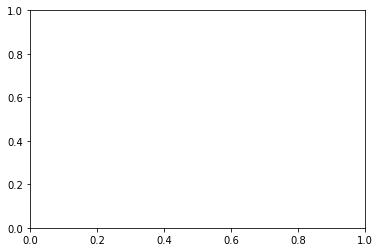

In [ ]:
print("BEST RMSE: " + str(min(RMSE_List)) + " in Epoch " + 
      str(Epoch_List[(RMSE_List.index(min(RMSE_List)))]) + " with Batch Size = " + str(BATCH_SIZE) + " \nLR = " + 
      str(LR_List[(RMSE_List.index(min(RMSE_List)))]))

# Plot de RMSE-Epoch
plt.plot(Epoch_List, RMSE_List, color='blue', linewidth = 3, marker='o', markerfacecolor='red', markersize=12)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Evolucion del RMSE por Epochs')
plt.show()

# Plot del LR-Epoch
plt.plot(Epoch_List, LR_List, color='blue', linewidth = 3, marker='o', markerfacecolor='red', markersize=12)
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.title('Evolucion del LR por Epochs')
plt.show()

## Print the Results

In [ ]:
print("Num Epochs mejor prueba: "+str(Epoch_List[RMSE_List.index(min(RMSE_List))]))
print("RMSE mejor prueba: "+str(RMSE_List[RMSE_List.index(min(RMSE_List))]))
print("")

labels = Label_List[(RMSE_List.index(min(RMSE_List)))]
predictions = Prediction_List[(RMSE_List.index(min(RMSE_List)))]

# Error promedio de cada una de las articulaciones
joint_error = np.zeros(3)
minimo = np.zeros(3)
maximo = np.zeros(3)
for i in range(3):
    joint_error[i] = sqrt(sklearn.metrics.mean_squared_error(predictions[:, i], labels[:, i]))
    minimo[i] = min(labels[:, i])
    maximo[i] = max(labels[:, i])
    
print("Error total por articulacion: "+str(joint_error))

for i in range(3):
    print("Articulacion " + str(i) + " [" + str(round(minimo[i], 2)) + " - " + str(round(maximo[i], 2)) + "] " +
          str(round(abs(round(minimo[i], 2) - round(maximo[i], 2)),2))
          , str(round(joint_error[i]*100/round(abs(round(minimo[i], 2) - round(maximo[i], 2)),2),2)) + "%")
    
'''    
for i in range(7):
    plt.plot(predictions[0:50, i], label='prediction')
    plt.plot(labels[0:50, i], label='target')
    plt.xlabel('Pruebas')
    plt.ylabel('Valor Accion')
    plt.title('Articulacion ' + str(i+1))
    plt.legend(['Prediction','Target'])
    plt.show()
'''    
print("")
try:
    #print(os.getcwd())
    observaciones=fnmatch.filter(os.listdir('Test_dataset'), '*.csv')
    print(observaciones)

    ordenado=[]
    for i in observaciones:
        if i.split(".")[0].split("_")[1]!="Actions":
            ordenado.append(int(i.split(".")[0].split("_")[1]))
    ordenado=sorted(ordenado)

    tamPruebas=[0]
    j=0
    for observacion in ordenado:
        observacion="0_"+str(observacion)+".csv"
        tam=len(pd.read_csv("Test_dataset/"+str(observacion)))
        j+=tam
        tamPruebas.append(j)

    #print(tamPruebas)
except:
    #print(os.getcwd())
    observaciones=fnmatch.filter(os.listdir('Test_dataset'), '0_V*')

    ordenado=[]
    for i in observaciones:
        ordenado.append(int(i.split(".")[0].split("_")[2]))
    ordenado=sorted(ordenado)

    tamPruebas=[0]
    j=0
    for observacion in ordenado:
        observacion="0_V_"+str(observacion)+".csv"
        tam=len(pd.read_csv("Test_dataset/"+str(observacion)))
        j+=tam
        tamPruebas.append(j)

    #print(tamPruebas)
print("")

#MSE por demostracion
mseDem=[]
rmseDem=[]
for j in range(len(tamPruebas)-1):
    mseDem.append(sklearn.metrics.mean_squared_error(labels[tamPruebas[j]:tamPruebas[j+1]], predictions[tamPruebas[j]:tamPruebas[j+1]]))
    rmseDem.append(sqrt(mseDem[j]))
''' 
print("Los valores del error cudratico medios (MSE) por demostracion son igual a "+str(mseDem[0:5]))
print("El valor medio de MSE es "+str(np.mean(mseDem)))
print("El valor maximo de MSE es "+str(max(mseDem))+" y equivale a la prueba "+str(np.argmax(mseDem)))
print("El valor minimo de MSE es "+str(min(mseDem))+" y equivale a la prueba "+str(np.argmin(mseDem)))
mMSE=sorted(mseDem)[0:5]
print("Mejores MSE: "+str(mMSE))
print("Mejores pruebas: "+str(mseDem.index(mMSE[0]))+", "+str(mseDem.index(mMSE[1]))+", "+str(mseDem.index(mMSE[2]))+", "+str(mseDem.index(mMSE[3]))+", "+str(mseDem.index(mMSE[4])))
pMSE=sorted(mseDem,reverse=True)[0:5]
print("Peores MSE: "+str(pMSE))
print("Peores pruebas: "+str(mseDem.index(pMSE[0]))+", "+str(mseDem.index(pMSE[1]))+", "+str(mseDem.index(pMSE[2]))+", "+str(mseDem.index(pMSE[3]))+", "+str(mseDem.index(pMSE[4])))

print("")
'''
print("Los valores RMSE por demostracion son igual a "+str(rmseDem[0:5]))
print("El valor medio de RMSE es "+str(np.mean(rmseDem)))
print("El valor maximo de RMSE es "+str(max(rmseDem))+" y equivale a la prueba "+str(np.argmax(rmseDem)))
print("El valor minimo de RMSE es "+str(min(rmseDem))+" y equivale a la prueba "+str(np.argmin(rmseDem)))
print("")
mRMSE=sorted(rmseDem)[0:5]
print("Mejores RMSE: "+str(mRMSE))
print("Mejores pruebas: "+str(rmseDem.index(mRMSE[0]))+", "+str(rmseDem.index(mRMSE[1]))+", "+str(rmseDem.index(mRMSE[2]))+", "+str(rmseDem.index(mRMSE[3]))+", "+str(rmseDem.index(mRMSE[4])))
print("Comienzan en la imagen: "+str(tamPruebas[rmseDem.index(mRMSE[0])])+", "+str(tamPruebas[rmseDem.index(mRMSE[1])])+", "+str(tamPruebas[rmseDem.index(mRMSE[2])])+", "+str(tamPruebas[rmseDem.index(mRMSE[3])])+", "+str(tamPruebas[rmseDem.index(mRMSE[4])]))
print("")
pRMSE=sorted(rmseDem,reverse=True)[0:5]
print("Peores RMSE: "+str(pRMSE))
print("Peores pruebas: "+str(rmseDem.index(pRMSE[0]))+", "+str(rmseDem.index(pRMSE[1]))+", "+str(rmseDem.index(pRMSE[2]))+", "+str(rmseDem.index(pRMSE[3]))+", "+str(rmseDem.index(pRMSE[4])))
print("Comienzan en la imagen: "+str(tamPruebas[rmseDem.index(pRMSE[0])])+", "+str(tamPruebas[rmseDem.index(pRMSE[1])])+", "+str(tamPruebas[rmseDem.index(pRMSE[2])])+", "+str(tamPruebas[rmseDem.index(pRMSE[3])])+", "+str(tamPruebas[rmseDem.index(pRMSE[4])]))
print("")

#Ploteamos la primera prueba
j=1
print("RMSE:",sqrt(sklearn.metrics.mean_squared_error(labels[tamPruebas[j]:tamPruebas[j+1]], predictions[tamPruebas[j]:tamPruebas[j+1]])))
for i in range(3):
    plt.plot(predictions[tamPruebas[j]:tamPruebas[j+1], i], label='prediction')
    plt.plot(labels[tamPruebas[j]:tamPruebas[j+1], i], label='target')
    plt.title("Observacion: " + str(j) +" - Articulacion " + str(i+1))
    plt.ylim(-1,1)
    plt.legend()
    plt.show()
    
#Ploteamos la peor prueba
j=np.argmax(rmseDem)
print("RMSE:",sqrt(sklearn.metrics.mean_squared_error(labels[tamPruebas[j]:tamPruebas[j+1]], predictions[tamPruebas[j]:tamPruebas[j+1]])))
for i in range(3):
    plt.plot(predictions[tamPruebas[j]:tamPruebas[j+1], i], label='prediction')
    plt.plot(labels[tamPruebas[j]:tamPruebas[j+1], i], label='target')
    plt.title("Observacion: " + str(j) +" - Articulacion " + str(i+1))
    plt.ylim(-1,1)
    plt.legend()
    plt.show()
    
#Ploteamos la mejor prueba
j=np.argmin(rmseDem)
print("RMSE:",sqrt(sklearn.metrics.mean_squared_error(labels[tamPruebas[j]:tamPruebas[j+1]], predictions[tamPruebas[j]:tamPruebas[j+1]])))
for i in range(3):
    plt.plot(predictions[tamPruebas[j]:tamPruebas[j+1], i], label='prediction')
    plt.plot(labels[tamPruebas[j]:tamPruebas[j+1], i], label='target')
    plt.title("Observacion: " + str(j) +" - Articulacion " + str(i+1))
    plt.ylim(-1,1)
    plt.legend()
    plt.show()

/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Num Epochs mejor prueba: 200
RMSE mejor prueba: 0.15936864274566392

Error total por articulacion: [0.12142455 0.19446099 0.15374051]
Articulacion 0 [-1.66 - 1.65] 3.31 3.67%
Articulacion 1 [-0.13 - 2.78] 2.91 6.68%
Articulacion 2 [-1.44 - 2.42] 3.86 3.98%

['Test_Actions.csv', 'Test_Actions_Normalized.csv']

Los valores RMSE por demostracion son igual a []
El valor medio de RMSE es nan
Traceback (most recent call last):
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_31854/2358071373.py", line 97, in <module>
    print("El valor maximo de RMSE es "+str(max(rmseDem))+" y equivale a la prueba "+str(np.argmax(rmseDem)))
ValueError: max() arg is an empty sequence

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/sit

## Histrogramas de RMSE por demostraciones Test

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_31854/1680554906.py", line 1, in <module>
    plt.hist(rmseDem,np.shape(rmseDem)[0],label="RMSE")
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/matplotlib/pyplot.py", line 2595, in hist
    **({"data": data} if data is not None else {}), **kwargs)
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/matplotlib/__init__.py", line 1412, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 6639, in hist
    m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)
  File "<__array_function__ internals>", line 6, in histogram
  File "/users/hodei.zia/anaconda3/envs/ImitAI

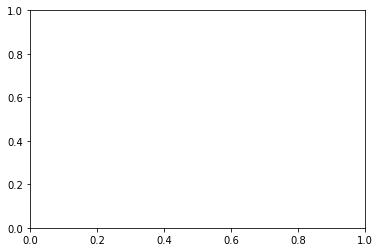

ERROR! Session/line number was not unique in database. History logging moved to new session 729


In [ ]:
plt.hist(rmseDem,np.shape(rmseDem)[0],label="RMSE")
#plt.bar(np.arange(np.shape(rmseDem)[0]),rmseDem,label="RMSE")
#plt.plot(np.arange(np.shape(rmseDem)[0]),rmseDem,label="RMSE")
plt.xlabel('RMSE')
plt.ylabel('Demostracion')
plt.title('Histrogrma de rangos de RMSE test')
plt.xlim(0,0.1)
plt.legend()
plt.show()
#plt.hist(rmseDem,np.shape(rmseDem)[0],label="RMSE")
plt.bar(np.arange(np.shape(rmseDem)[0]),rmseDem,label="RMSE")
#plt.plot(np.arange(np.shape(rmseDem)[0]),rmseDem,label="RMSE")
plt.xlabel('Demostracion')
plt.ylabel('RMSE')
plt.title('Histrogrma de RMSE por demostraciones test')
plt.ylim(0,0.1)
plt.legend()
plt.show()

## Save the Model

In [51]:
print("DATOS DEL MODELO:")
print(" - Numero de Epoch: " + str(Epoch_List[(RMSE_List.index(min(RMSE_List)))]))
print(" - RMSE: " + str(min(RMSE_List)))
torch.save(Model_List[(RMSE_List.index(min(RMSE_List)))], 'model_pytorch_01593')
model = torch.load('model_pytorch_01593')
model.eval()

DATOS DEL MODELO:
 - Numero de Epoch: 36
 - RMSE: 0.15936864274566392
ERROR! Session/line number was not unique in database. History logging moved to new session 727


MultiImage(
  (fe): Sequential(
    (0): Conv2d(36, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
